# Imports

In [1]:
import os
import time

In [2]:
from IPython import display

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, optimizers, losses, datasets, Sequential

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Vars

In [5]:
BUFFER_SIZE = 100000
EPOCHS = 100
BATCH_SIZE = 2**5
NOISE_DIM = int(10e1)

# Data process

In [6]:
(train_images, _), (_, _) = datasets.mnist.load_data()

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images) / 255.0

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [10]:
def make_generator_model():
    model = Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(
        layers.Conv2DTranspose(
            128, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(
        layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(
        layers.Conv2DTranspose(
            1,
            (5, 5),
            strides=(2, 2),
            padding="same",
            use_bias=False,
            activation="sigmoid",
        )
    )

    return model

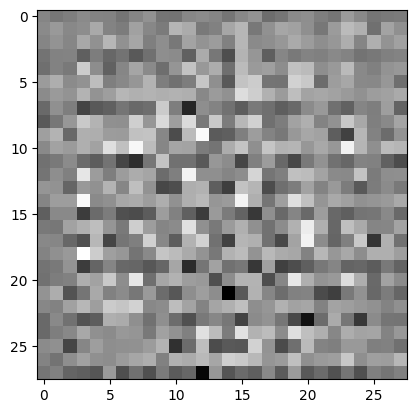

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [12]:
def make_descriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_descriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02182743]], dtype=float32)>

In [14]:
# Функция вычисления loss
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
num_examples_to_generate = 16

SEED = tf.random.normal([num_examples_to_generate, NOISE_DIM])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

In [21]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(7, 7))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")

    plt.savefig("images/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [22]:
def train(dataset, epochs: int):
    count_batches = len(dataset)
    print(f"total epochs: {epochs}")
    print()

    for epoch in range(epochs):

        print(f"epoch {epoch + 1} / {epochs}")

        start = time.time()

        for index_batch, image_batch in enumerate(dataset):
            print(f"{index_batch + 1} / {count_batches}")

            train_step(image_batch)

        display.clear_output(wait=True)

        generate_and_save_images(generator, epoch + 1, SEED)

        if (epoch + 1) % 5 == 0:

            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")
        print()

    display.clear_output(wait=True)

    generate_and_save_images(generator, epochs, SEED)

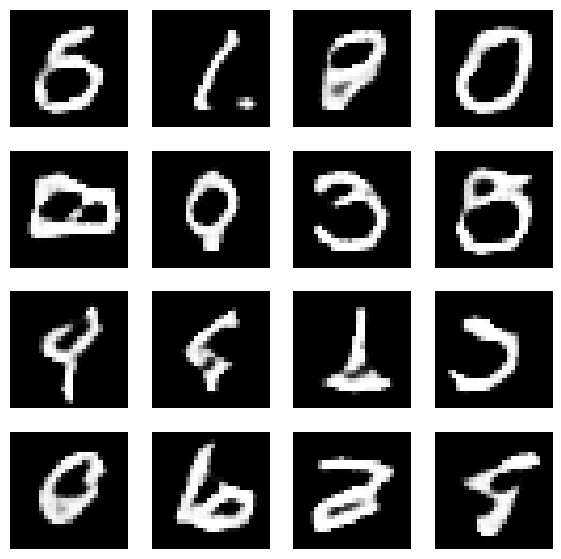

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
discriminator.save("models/discriminator.keras")
generator.save("models/generator.keras")

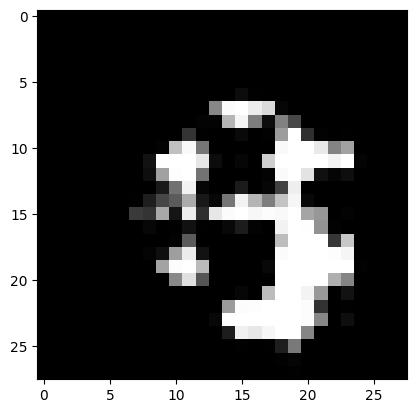

In [ ]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.show()